# Paso 4: Data mining

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
dfcat = pd.read_csv(r'F:\2022-1\Analisis de datos\Tarea Academica\dfcat_post_trans.csv')
dfnum = pd.read_csv(r'F:\2022-1\Analisis de datos\Tarea Academica\dfnum_sin_outliers.csv')

In [3]:
dfunion = pd.concat([dfnum,dfcat], axis = 1)

In [4]:
# Eliminamos columnas sin informacion relevante o que no podremos usar dentro de los modelos de clasificacion
dfunion.drop(columns = ["popularity","key", "id", "id_artists", "release_year"], inplace = True)
dfunion.head()

,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,explicit,mode,time_signature,Name_Length,words_name,release_month,release_day,release_trim,list_pop,list_key
0,5.103472,0.645,0.4450,-13.338,-0.344862,0.674,-0.127844,0.151,0.127,104.851,0,1,3,5.0,1.0,2,22,1,0,0
1,4.992111,0.695,0.2630,-22.136,-1.258605,0.797,-3.000000,0.148,0.655,102.009,0,1,1,31.0,5.0,6,1,2,0,0
2,5.259211,0.434,0.1770,-21.180,-1.282329,0.994,-1.642065,0.212,0.457,130.418,0,1,5,30.0,5.0,3,21,1,0,2
3,5.247745,0.321,0.0946,-27.961,-1.289037,0.995,-2.165238,0.104,0.397,169.980,0,1,3,26.0,4.0,3,21,1,0,0
4,5.212401,0.402,0.1580,-16.900,-1.397940,0.989,-0.882729,0.311,0.196,103.220,0,0,4,16.0,4.0,1,1,1,0,1


In [5]:
dfunion.dropna(inplace=True)

### Separar en variable dependiente y variable independiente

In [6]:
y = dfunion["list_pop"]
x = dfunion[['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'explicit', 'mode', 'time_signature', 'Name_Length', 'words_name',
       'release_month', 'release_day', 'release_trim','list_key']]

### Sample splitting

In [7]:
# dividimos en conjunto de train, test y validation
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=100, stratify=y)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=200, stratify=y_train)

## Modelos 

### Balanceo de datos: SMOTE

In [8]:
pd.DataFrame(y_train).value_counts(normalize=True)*100

list_pop
0           73.128421
1           26.871579
dtype: float64

In [9]:
pd.DataFrame(y_train).value_counts()

list_pop
0           241296
1            88666
dtype: int64

Nuestra variable no está tan desbalanceada, sin embargo el 73% de los datos hacen referencia a canciones no populares y solo el 27% a canciones populares.

In [10]:
nas = pd.DataFrame(x_train.isnull().sum()).sort_values(0,ascending=False)
nas.columns = ['nas']
nas['nas%'] = round(nas['nas']/x_train.shape[0], 2)
nas 

,nas,nas%
duration_ms,0,0.0
explicit,0,0.0
release_trim,0,0.0
release_day,0,0.0
release_month,0,0.0
words_name,0,0.0
Name_Length,0,0.0
time_signature,0,0.0
mode,0,0.0
tempo,0,0.0


No tenemos valores nulos, asi que podemos generar datos balanceados

### Smote con remuestreo de todos los datos

In [11]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter 

os_us = SMOTETomek(random_state=2022, sampling_strategy='all' ) #

x_train_smote, y_train_smote = os_us.fit_resample(x_train, y_train)

#x_train_all_smote, y_train_all_smote = os_us.fit_resample(x_train, y_train)

In [12]:
print(y_train.value_counts(normalize=True)*100) #antes del balanceo
print(y_train_smote.value_counts(normalize=True)*100) #luego de aplicar la tecnica smote
print(y_train_smote.value_counts()) #luego de aplicar la tecnica smote

0    73.128421
1    26.871579
Name: list_pop, dtype: float64
1    50.0
0    50.0
Name: list_pop, dtype: float64
1    237061
0    237061
Name: list_pop, dtype: int64


### Árbol de clasificación CART sin datos balanceados

Elegimos el modelo

In [13]:
from sklearn.tree import DecisionTreeClassifier

# Creacion del modelo 
modelo1 = DecisionTreeClassifier(criterion="gini", random_state=2022)

In [14]:
# Entrenamiento del modelo 
modelo1.fit(x_train, y_train)

DecisionTreeClassifier(random_state=2022)

Realizamos predicciones con datos de test

In [15]:
# Realizamos predicciones con datos de test
y_predict_modelo1 = modelo1.predict(x_test)
y_predict_modelo1

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [16]:
# Se calcula el accuracy
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
accuracy_score(y_test, y_predict_modelo1) 

0.6961834559600685

In [17]:
from sklearn.model_selection import cross_val_score

scores_res = cross_val_score(modelo1, x_train_smote, y_train_smote, cv=10)
print("Accuracy de los 10 folds:", scores_res)
print("Accuracy Mean: {:.3f} (std: {:.3f})".format(scores_res.mean(), scores_res.std()) )

Accuracy de los 10 folds: [0.66422711 0.66429038 0.66270143 0.70849152 0.76786468 0.76543913
 0.76600861 0.76818105 0.76999494 0.76925673]
Accuracy Mean: 0.731 (std: 0.047)


In [18]:
# Se genera el arbol de clasificacion - modelo1
target = list(y_test.unique())
feature_names = list(x_train.columns)

Guardamos el modelo

In [19]:
import pickle 
pickle.dump(modelo1, open('modelo1', 'wb')) 

### Ánalisis del modelo

In [52]:
def indicadores(TP, FP, TN, FN):
    Sensibility = TP/(TP+FN)
    print( 'Sensibilidad es:',Sensibility)
    Specificity = TN/(TN+FP)
    print('Especificidad es:', Specificity)
    Precision = TP/(TP+FP)
    print('Precision es:', Precision)
    Recall = TP/(TP+FN)
    print('Recall es:', Recall)
    F1 = 2*(Precision*Recall)/(Precision+Recall)
    print('F1 es:', F1)
    return Sensibility, Specificity, Precision, Recall, F1

Matriz de confusion

In [21]:
# Confusion matrix modelo1
print(pd.crosstab(y_test, y_predict_modelo1))

col_0         0      1
list_pop              
0         84122  23121
1         21434  17974


In [22]:
# indicadores(TP, FP, TN, FN)
modelo_arbol_cart_nobal = indicadores(17974, 23121, 84122, 21434)

Sensibilidad es: 0.45610028420625254
Especificidad es: 0.7844055089842694
Precision es: 0.4373768098308797
Recall es: 0.45610028420625254
F1 es: 0.4465423648808119


### Árbol de clasificación CART con datos balanceados

In [23]:
from sklearn.tree import DecisionTreeClassifier

# Creacion del modelo 
# modelo1 = DecisionTreeClassifier(criterion="gini", random_state=2022)
modelo2 = DecisionTreeClassifier(criterion="gini", random_state=2022)
# Indicador gini ayuda a medir la calidad de la división de los datos

In [24]:
# Entrenamiento del modelo 
modelo2.fit(x_train_smote, y_train_smote)

DecisionTreeClassifier(random_state=2022)

Realizamos predicciones con datos de test

In [25]:
# Realizamos predicciones con datos de test
y_predict_modelo2 = modelo2.predict(x_test)
y_predict_modelo2

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [26]:
# Se calcula el accuracy
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
accuracy_score(y_test, y_predict_modelo2) 

0.6709671260339173

In [27]:
from sklearn.model_selection import cross_val_score

scores_res = cross_val_score(modelo2, x_train, y_train, cv=10)
print("Accuracy de los 10 folds:", scores_res)
print("Accuracy Mean: {:.3f} (std: {:.3f})".format(scores_res.mean(), scores_res.std()) )

Accuracy de los 10 folds: [0.69733612 0.69654817 0.69820584 0.69511456 0.6993575  0.70029701
 0.69508425 0.6935083  0.69423566 0.69405382]
Accuracy Mean: 0.696 (std: 0.002)


In [28]:
# Se genera el arbol de clasificacion - modelo1b
target = list(y_test.unique())
feature_names = list(x_train_smote.columns)

Guardamos el modelo

In [29]:
import pickle 
pickle.dump(modelo2, open('modelo2', 'wb')) 

Ánalisis del modelo

In [30]:
# Confusion matrix modelo1b
print(pd.crosstab(y_test, y_predict_modelo2))

col_0         0      1
list_pop              
0         77330  29913
1         18340  21068


In [31]:
# indicadores(TP, FP, TN, FN)
modelo_arbol_cart_bal = indicadores(21068, 29913, 77330, 18340)

Sensibilidad es: 0.5346122614697524
Especificidad es: 0.7210727040459517
Precision es: 0.41325199584158806
Recall es: 0.5346122614697524
F1 es: 0.46616291805418797


## Árbol de clasificación CART con datos balanceados y grid search

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

#Se establecen las variables que el GridSearch va buscar
parameters = {
        "criterion": ["gini", "entropy"],
        "random_state": [0],
        "splitter": ["best", "random"],
    }

#Definimos el modelo
model3 = DecisionTreeClassifier()

#Se prepara el Stratified Cross-Validation
grid_search = GridSearchCV(model3, param_grid=parameters, cv=5, n_jobs=-1, scoring="accuracy")

In [33]:
# Entrenamiento del modelo 
grid_search.fit(x_train_smote, y_train_smote)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'random_state': [0],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [34]:
model3 = grid_search.best_estimator_
model3

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [35]:
best_params = grid_search.best_params_
best_params

{'criterion': 'entropy', 'random_state': 0, 'splitter': 'best'}

In [36]:
#Revisamos el accuracy en el conjunto de prueba
model3.score(x_test, y_test)

0.6746220619020669

In [40]:
#Revisamos el accuracy en el conjunto de prueba
model3.score(x_val, y_val)

0.6722096956031567

In [38]:
# Realizamos predicciones con datos de test
y_predict_modelo3 = model3.predict(x_test)
y_predict_modelo3

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [39]:
# Se calcula el accuracy
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
accuracy_score(y_test, y_predict_modelo3) 

0.6746220619020669

In [42]:
from sklearn.model_selection import cross_val_score

scores_res = cross_val_score(model3, x_train, y_train, cv=10)
print("Accuracy de los 10 folds:", scores_res)
print("Accuracy Mean: {:.3f} (std: {:.3f})".format(scores_res.mean(), scores_res.std()) )

Accuracy de los 10 folds: [0.70063945 0.70006364 0.69947872 0.7034489  0.70396412 0.69781186
 0.70275185 0.70093345 0.69714511 0.70011517]
Accuracy Mean: 0.701 (std: 0.002)


Ánalisis del modelo

Matriz de confusión

In [43]:
# Confusion matrix modelo1b
print(pd.crosstab(y_test, y_predict_modelo3))

col_0         0      1
list_pop              
0         77708  29535
1         18182  21226


In [47]:
# indicadores(TP, FP, TN, FN)
model3 = indicadores(21226, 29535, 77708, 18182)

Sensibilidad es: 0.5386215996751929
Especificidad es: 0.7245974096211407
Precision es: 0.4181556706920667
Recall es: 0.5386215996751929
F1 es: 0.4708048220563608


Guardamos el modelos

In [46]:
import pickle 
pickle.dump(model3, open('modelo3', 'wb')) 

## Regresión logísitica con datos no balanceados

In [48]:
#Escalamiento de las variables
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

#Se establecen las variables que el GridSearch va buscar
parameters = {
        "max_iter": [50, 200],
        "random_state": [0]
    }

#Definimos el modelo
model4 = LogisticRegression()

#Se prepara el Stratified Cross-Validation
grid_search = GridSearchCV(model4, param_grid=parameters, cv=5, n_jobs=-1, scoring="accuracy")

In [50]:
#Se entrena el modelo
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'max_iter': [50, 200], 'random_state': [0]},
             scoring='accuracy')

In [51]:
model4 = grid_search.best_estimator_
model4

LogisticRegression(max_iter=200, random_state=0)

In [52]:
best_params = grid_search.best_params_
best_params

{'max_iter': 200, 'random_state': 0}

Evaluamos

In [53]:
#Revisamos el accuracy en el conjunto de prueba
model4.score(x_test, y_test)

0.7580241525799347

In [54]:
# Realizamos predicciones con datos de test
y_predict_modelo4 = model4.predict(x_test)
y_predict_modelo4

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [56]:
from sklearn.model_selection import cross_val_score

scores_res = cross_val_score(model4, x_train, y_train, cv=10)
print("Accuracy de los 10 folds:", scores_res)
print("Accuracy Mean: {:.3f} (std: {:.3f})".format(scores_res.mean(), scores_res.std()) )

Accuracy de los 10 folds: [0.75412916 0.75767494 0.75457631 0.75784944 0.75606134 0.75460662
 0.75663717 0.75657655 0.75351558 0.75621287]
Accuracy Mean: 0.756 (std: 0.001)


Análisis de los modelos

In [57]:
# Confusion matrix modelo1
print(pd.crosstab(y_test, y_predict_modelo4))

col_0          0      1
list_pop               
0         100794   6449
1          29037  10371


In [59]:
model4 = indicadores(10371, 6449, 100794, 29037)

Sensibilidad es: 0.26316991473812423
Especificidad es: 0.9398655390095391
Precision es: 0.6165873959571938
Recall es: 0.26316991473812423
F1 es: 0.3688909440136587


In [70]:
import pickle 
pickle.dump(model4, open('modelo4', 'wb')) 

## Regresión logísitica con datos balanceados y grid search

In [14]:
#Escalamiento de las variables
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

x_train_smote = scaler.fit_transform(x_train_smote)
# x_test = scaler.transform(x_test)

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

#Se establecen las variables que el GridSearch va buscar
parameters = {
        "max_iter": [50, 200],
        "random_state": [0]
    }

#Definimos el modelo
model5 = LogisticRegression()

#Se prepara el Stratified Cross-Validation
grid_search = GridSearchCV(model5, param_grid=parameters, cv=5, n_jobs=-1, scoring="accuracy")

In [16]:
#Se entrena el modelo
grid_search.fit(x_train_smote, y_train_smote)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'max_iter': [50, 200], 'random_state': [0]},
             scoring='accuracy')

In [17]:
model5 = grid_search.best_estimator_
model5

LogisticRegression(max_iter=200, random_state=0)

In [18]:
best_params = grid_search.best_params_
best_params

{'max_iter': 200, 'random_state': 0}

In [19]:
#Revisamos el accuracy en el conjunto de prueba
model5.score(x_test, y_test)

c:\Users\c3318\anaconda3\envs\Jypiter_with_R\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.7300666207526713

In [20]:
# Realizamos predicciones con datos de test
y_predict_modelo5 = model5.predict(x_test)
y_predict_modelo5

c:\Users\c3318\anaconda3\envs\Jypiter_with_R\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [69]:
from sklearn.model_selection import cross_val_score

scores_res = cross_val_score(model5, x_train, y_train, cv=10)
print("Accuracy de los 10 folds:", scores_res)
print("Accuracy Mean: {:.3f} (std: {:.3f})".format(scores_res.mean(), scores_res.std()) )

Accuracy de los 10 folds: [0.75412916 0.75767494 0.75457631 0.75784944 0.75606134 0.75460662
 0.75663717 0.75657655 0.75351558 0.75621287]
Accuracy Mean: 0.756 (std: 0.001)


Análisis del modelo

In [252]:
# Confusion matrix modelo1
print(pd.crosstab(y_test, y_predict_modelo5))

col_0         0      1
list_pop              
0         72241  35002
1         12044  27364


In [253]:
model5 = indicadores(27364, 35002, 72241, 12044)

Sensibilidad es: 0.6943767762890783
Especificidad es: 0.6736197234318324
Precision es: 0.43876471154154506
Recall es: 0.6943767762890783
F1 es: 0.537740483817085


In [71]:
import pickle 
pickle.dump(model5, open('modelo5', 'wb')) 

In [32]:
x_train_smote = pd.DataFrame(x_train_smote, columns = x_train.columns)

In [33]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

model_red = sm.Logit(y_train_smote, x_train_smote)
model_red = model_red.fit()
print(model_red.summary())

Optimization terminated successfully.
         Current function value: 0.577220
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               list_pop   No. Observations:               474122
Model:                          Logit   Df Residuals:                   474103
Method:                           MLE   Df Model:                           18
Date:                Fri, 01 Jul 2022   Pseudo R-squ.:                  0.1672
Time:                        16:02:59   Log-Likelihood:            -2.7367e+05
converged:                       True   LL-Null:                   -3.2864e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
duration_ms          0.9993      0.027     36.854      0.000       0.946       1.052
danceabilit

## Random forest classifier con datos balanceados

In [348]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#Se establecen las variables que el GridSearch va buscar
parameters = {
        "criterion": ["gini", "entropy"],
        "random_state": [0]
    }

#Definimos el modelo
model9 = RandomForestClassifier()

#Se prepara el Stratified Cross-Validation
grid_search = GridSearchCV(model9, param_grid=parameters, cv=5, n_jobs=-1, scoring="accuracy")

In [349]:
# Entrenamiento del modelo 
grid_search.fit(x_resampled, y_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'random_state': [0]},
             scoring='accuracy')

In [350]:
model9 = grid_search.best_estimator_
model9

RandomForestClassifier(criterion='entropy', random_state=0)

In [351]:
best_params = grid_search.best_params_
best_params

{'criterion': 'entropy', 'random_state': 0}

In [352]:
# Realizamos predicciones con datos de test
y_predict_modelo9 = model9.predict(x_test)
y_predict_modelo9

c:\Users\c3318\anaconda3\envs\Jypiter_with_R\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [353]:
#Revisamos el accuracy en el conjunto de prueba
model9.score(x_test, y_test)

c:\Users\c3318\anaconda3\envs\Jypiter_with_R\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.7316076944582717

In [354]:
# Confusion matrix modelo1b
print(pd.crosstab(y_test, y_predict_modelo9))

col_0          0    1
list_pop             
0         106796  447
1          38913  495


In [355]:
# indicadores(TP, FP, TN, FN)
modelo9 = indicadores(495, 447, 106796, 38913)

Sensibilidad es: 0.012560901339829476
Especificidad es: 0.9958318957880701
Precision es: 0.5254777070063694
Recall es: 0.012560901339829476
F1 es: 0.02453531598513011


## Random forest classfier con datos balanceados SMOTE

In [356]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#Se establecen las variables que el GridSearch va buscar
parameters = {
        "criterion": ["gini", "entropy"],
        "random_state": [0]
    }

#Definimos el modelo
model10 = RandomForestClassifier()

#Se prepara el Stratified Cross-Validation
grid_search = GridSearchCV(model10, param_grid=parameters, cv=5, n_jobs=-1, scoring="accuracy")

In [357]:
# Entrenamiento del modelo 
grid_search.fit(x_train_smote, y_train_smote)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'random_state': [0]},
             scoring='accuracy')

In [358]:
model10 = grid_search.best_estimator_
model10

RandomForestClassifier(criterion='entropy', random_state=0)

In [359]:
best_params = grid_search.best_params_
best_params

{'criterion': 'entropy', 'random_state': 0}

In [360]:
# Realizamos predicciones con datos de test
y_predict_modelo10 = model10.predict(x_test)
y_predict_modelo10

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [361]:
#Revisamos el accuracy en el conjunto de prueba
model10.score(x_test, y_test)

0.747298006832548

In [362]:
# Confusion matrix modelo1b
print(pd.crosstab(y_test, y_predict_modelo10))

col_0         0      1
list_pop              
0         86467  20776
1         16283  23125


In [363]:
# indicadores(TP, FP, TN, FN)
modelo10 = indicadores(23125, 20776, 86467, 16283)

Sensibilidad es: 0.5868097848152659
Especificidad es: 0.8062717380155349
Precision es: 0.5267533769162434
Recall es: 0.5868097848152659
F1 es: 0.555162107335342


### Otro tipo de balanceo de datos

In [34]:
dfcat = pd.read_csv(r'F:\2022-1\Analisis de datos\Tarea Academica\dfcat_post_trans.csv')
dfnum = pd.read_csv(r'F:\2022-1\Analisis de datos\Tarea Academica\dfnum_sin_outliers.csv')

In [35]:
dfunion = pd.concat([dfnum,dfcat], axis = 1)

In [36]:
# Eliminamos columnas sin informacion relevante o que no podremos usar dentro de los modelos de clasificacion
dfunion.drop(columns = ["popularity","key", "id", "id_artists", "release_year"], inplace = True)
dfunion.head()

,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,explicit,mode,time_signature,Name_Length,words_name,release_month,release_day,release_trim,list_pop,list_key
0,5.103472,0.645,0.4450,-13.338,-0.344862,0.674,-0.127844,0.151,0.127,104.851,0,1,3,5.0,1.0,2,22,1,0,0
1,4.992111,0.695,0.2630,-22.136,-1.258605,0.797,-3.000000,0.148,0.655,102.009,0,1,1,31.0,5.0,6,1,2,0,0
2,5.259211,0.434,0.1770,-21.180,-1.282329,0.994,-1.642065,0.212,0.457,130.418,0,1,5,30.0,5.0,3,21,1,0,2
3,5.247745,0.321,0.0946,-27.961,-1.289037,0.995,-2.165238,0.104,0.397,169.980,0,1,3,26.0,4.0,3,21,1,0,0
4,5.212401,0.402,0.1580,-16.900,-1.397940,0.989,-0.882729,0.311,0.196,103.220,0,0,4,16.0,4.0,1,1,1,0,1


In [37]:
dfunion.dropna(inplace=True)

In [38]:
y = dfunion["list_pop"]
x = dfunion[['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'explicit', 'mode', 'time_signature', 'Name_Length', 'words_name',
       'release_month', 'release_day', 'release_trim','list_key']]

In [39]:
# dividimos en conjunto de train, test y validation
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=100, stratify=y)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=200, stratify=y_train)

In [40]:
pd.DataFrame(y_train).value_counts(normalize=True)*100

list_pop
0           73.128421
1           26.871579
dtype: float64

In [41]:
pd.DataFrame(y_train).value_counts()

list_pop
0           241296
1            88666
dtype: int64

In [42]:
nas = pd.DataFrame(x_train.isnull().sum()).sort_values(0,ascending=False)
nas.columns = ['nas']
nas['nas%'] = round(nas['nas']/x_train.shape[0], 2)
nas 

,nas,nas%
duration_ms,0,0.0
explicit,0,0.0
release_trim,0,0.0
release_day,0,0.0
release_month,0,0.0
words_name,0,0.0
Name_Length,0,0.0
time_signature,0,0.0
mode,0,0.0
tempo,0,0.0


### Under-sampling

In [43]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
x_resampled, y_resampled = rus.fit_resample(x_train, y_train)

In [44]:
print(y_train.value_counts(normalize=True)*100) #antes del balanceo
print(y_train.value_counts()) 

print(y_resampled.value_counts(normalize=True)*100)
print(y_resampled.value_counts())

0    73.128421
1    26.871579
Name: list_pop, dtype: float64
0    241296
1     88666
Name: list_pop, dtype: int64
0    50.0
1    50.0
Name: list_pop, dtype: float64
0    88666
1    88666
Name: list_pop, dtype: int64


## Árbol de clasificación CART con datos balanceados

In [45]:
from sklearn.tree import DecisionTreeClassifier

# Creacion del modelo 
modelo6 = DecisionTreeClassifier(criterion="gini", random_state=2022)
# Indicador gini ayuda a medir la calidad de la división de los datos

In [46]:
# Entrenamiento del modelo 
modelo6.fit(x_resampled, y_resampled)

DecisionTreeClassifier(random_state=2022)

In [47]:
# Realizamos predicciones con datos de test
y_predict_modelo6 = modelo6.predict(x_test)
y_predict_modelo6

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [48]:
# Se calcula el accuracy
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
accuracy_score(y_test, y_predict_modelo6) 

0.6342677513279827

In [49]:
from sklearn.model_selection import cross_val_score

scores_res = cross_val_score(modelo6, x_train, y_train, cv=10)
print("Accuracy de los 10 folds:", scores_res)
print("Accuracy Mean: {:.3f} (std: {:.3f})".format(scores_res.mean(), scores_res.std()) )

Accuracy de los 10 folds: [0.69733612 0.69654817 0.69820584 0.69511456 0.6993575  0.70029701
 0.69508425 0.6935083  0.69423566 0.69405382]
Accuracy Mean: 0.696 (std: 0.002)


In [50]:
# Confusion matrix modelo1b
print(pd.crosstab(y_test, y_predict_modelo6))

col_0         0      1
list_pop              
0         67992  39251
1         14384  25024


In [53]:
# indicadores(TP, FP, TN, FN)
modelo6 = indicadores(25024, 39251, 67992, 14384)

Sensibilidad es: 0.634997969955339
Especificidad es: 0.6339994218736887
Precision es: 0.3893271100739012
Recall es: 0.634997969955339
F1 es: 0.48270208230857514


Guardamos el modelo

In [54]:
import pickle 
pickle.dump(modelo6, open('modelo6', 'wb')) 

## Árbol de clasificación CART con datos balanceados y grid search

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

#Se establecen las variables que el GridSearch va buscar
parameters = {
        "criterion": ["gini", "entropy"],
        "random_state": [0],
        "splitter": ["best", "random"],
    }

#Definimos el modelo
model7 = DecisionTreeClassifier()

#Se prepara el Stratified Cross-Validation
grid_search = GridSearchCV(model7, param_grid=parameters, cv=5, n_jobs=-1, scoring="accuracy")

In [56]:
# Entrenamiento del modelo 
grid_search.fit(x_resampled, y_resampled)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'random_state': [0],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [57]:
model7 = grid_search.best_estimator_
model7

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [58]:
best_params = grid_search.best_params_
best_params

{'criterion': 'entropy', 'random_state': 0, 'splitter': 'best'}

In [59]:
#Revisamos el accuracy en el conjunto de prueba
model7.score(x_test, y_test)

0.6362997865681107

In [61]:
# Realizamos predicciones con datos de test
y_predict_modelo7 = model7.predict(x_test)
y_predict_modelo7

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [98]:
from sklearn.model_selection import cross_val_score

scores_res = cross_val_score(model7, x_train, y_train, cv=10)
print("Accuracy de los 10 folds:", scores_res)
print("Accuracy Mean: {:.3f} (std: {:.3f})".format(scores_res.mean(), scores_res.std()) )

Accuracy de los 10 folds: [0.70063945 0.70006364 0.69947872 0.7034489  0.70396412 0.69781186
 0.70275185 0.70093345 0.69714511 0.70011517]
Accuracy Mean: 0.701 (std: 0.002)


Análisis del modelo

Matriz de confusión

In [62]:
# Confusion matrix modelo1b
print(pd.crosstab(y_test, y_predict_modelo7))

col_0         0      1
list_pop              
0         68225  39018
1         14319  25089


In [63]:
# indicadores(TP, FP, TN, FN)
modelo7 = indicadores(25089, 39018, 68225, 14319)

Sensibilidad es: 0.6366473812423873
Especificidad es: 0.6361720578499296
Precision es: 0.39136131779680844
Recall es: 0.6366473812423873
F1 es: 0.4847413418345167


In [65]:
# let's create a dictionary of features and their importance values
feat_dict= {}
for col, val in sorted(zip(x_train_smote.columns, model7.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val

In [66]:
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
feat_df

,Feature,Importance
0,loudness,0.146186
1,acousticness,0.093584
2,duration_ms,0.082657
3,valence,0.074141
4,danceability,0.073326
5,tempo,0.069090
6,liveness,0.068458
7,energy,0.068318
8,speechiness,0.067553
9,release_day,0.059373


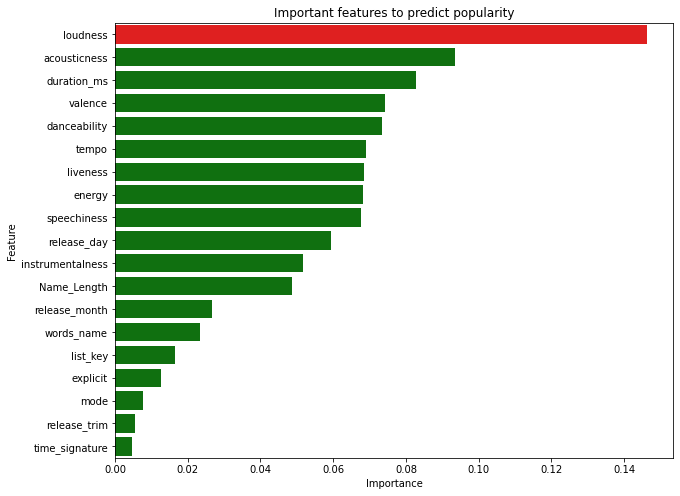

In [68]:
values = feat_df.Importance    
idx = feat_df.Feature
plt.figure(figsize=(10,8))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features to predict popularity')
plt.show()

In [101]:
import pickle 
pickle.dump(model7, open('modelo7', 'wb')) 

## Regresión logísitica con datos balanceados y grid search

In [102]:
#Escalamiento de las variables
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

x_resampled = scaler.fit_transform(x_resampled)
# x_test = scaler.transform(x_test)

In [103]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

#Se establecen las variables que el GridSearch va buscar
parameters = {
        "max_iter": [50, 200],
        "random_state": [0]
    }

#Definimos el modelo
model8 = LogisticRegression()

#Se prepara el Stratified Cross-Validation
grid_search = GridSearchCV(model8, param_grid=parameters, cv=5, n_jobs=-1, scoring="accuracy")

In [104]:
#Se entrena el modelo
grid_search.fit(x_resampled, y_resampled)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'max_iter': [50, 200], 'random_state': [0]},
             scoring='accuracy')

In [105]:
model8 = grid_search.best_estimator_
model8

LogisticRegression(max_iter=200, random_state=0)

In [106]:
best_params = grid_search.best_params_
best_params

{'max_iter': 200, 'random_state': 0}

In [107]:
#Revisamos el accuracy en el conjunto de prueba
model8.score(x_test, y_test)

c:\Users\c3318\anaconda3\envs\Jypiter_with_R\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.72933017845088

In [108]:
# Realizamos predicciones con datos de test
y_predict_modelo8 = model8.predict(x_test)
y_predict_modelo8

c:\Users\c3318\anaconda3\envs\Jypiter_with_R\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [109]:
from sklearn.model_selection import cross_val_score

scores_res = cross_val_score(model8, x_train, y_train, cv=10)
print("Accuracy de los 10 folds:", scores_res)
print("Accuracy Mean: {:.3f} (std: {:.3f})".format(scores_res.mean(), scores_res.std()) )

c:\Users\c3318\anaconda3\envs\Jypiter_with_R\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\c3318\anaconda3\envs\Jypiter_with_R\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Accuracy de los 10 folds: [0.75567476 0.75846289 0.75603103 0.75630379 0.75597042 0.75560674
 0.75648563 0.75666747 0.75306098 0.75697054]
Accuracy Mean: 0.756 (std: 0.001)


c:\Users\c3318\anaconda3\envs\Jypiter_with_R\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Análisis de los modelos 

In [110]:
# Confusion matrix modelo1
print(pd.crosstab(y_test, y_predict_modelo8))

col_0          0     1
list_pop              
0         103818  3425
1          36269  3139


In [111]:
modelo_logit2 = indicadores(3139, 3425, 103818, 36269)

Sensibilidad es: 0.07965387738530248
Especificidad es: 0.9680631836110516
Precision es: 0.47821450335161486
Recall es: 0.07965387738530248
F1 es: 0.13656138519098582
